In [1]:
import numpy as np
import random
import tensorflow as tf
import matplotlib.pyplot as plt
import grpc

import simulation_service_pb2 as v1
import simulation_service_pb2_grpc as v1GRPC

# Helper functions

In [3]:
actions = [
    ["MOVE", "UP"],
    ["MOVE", "DOWN"],
    ["MOVE", "LEFT"],
    ["MOVE", "RIGHT"],
    ["CONSUME", "UP"],
    ["CONSUME", "DOWN"],
    ["CONSUME", "LEFT"],
    ["CONSUME", "RIGHT"],
    ["WAIT", "DOWN"]
]

def randomAction():
    return random.randint(0, 8)
def cellStringToNumber(s):
    if (s == "EMPTY"):
        return 0
    elif (s == "FOOD"):
        return 1
    else:
        return 0
    

# Initialize the graph

In [4]:
tf.reset_default_graph()

In [5]:
#These lines establish the feed-forward part of the network used to choose actions
inputs1 = tf.placeholder(shape=[1,8],dtype=tf.float32)
W = tf.Variable(tf.random_uniform([8,9],0,0.01))
Qout = tf.matmul(inputs1,W)
predict = tf.argmax(Qout,1)

#Below we obtain the loss by taking the sum of squares difference between the target and prediction Q values.
nextQ = tf.placeholder(shape=[1,9],dtype=tf.float32)
loss = tf.reduce_sum(tf.square(nextQ - Qout))
trainer = tf.train.GradientDescentOptimizer(learning_rate=0.1)
updateModel = trainer.minimize(loss)

# Initialize the env stub

In [8]:
channel = grpc.insecure_channel('localhost:9090')
stub = v1GRPC.SimulationServiceStub(channel)
metadata = [('auth-secret', 'MOCK-SECRET')]
api="v1"

# Train the model

In [9]:
init = tf.initialize_all_variables()

# 
minScore = 70
# Set learning parameters
y = .99
e = 0.1
num_episodes = 1000
#create lists to contain total rewards and steps per episode
jList = []
rList = []
with tf.Session() as sess:
    sess.run(init)
    for i in range(num_episodes):
        
        # Reset environment
        stub.ResetWorld(v1.ResetWorldRequest(), metadata=metadata)
        # Spawn a new agent
        spawnAgentRes = stub.CreateAgent(v1.CreateAgentRequest(api="v1", x=0, y=0), metadata=metadata)
        agentId = spawnAgentRes.id 
        # Get the first observation
        obsvResp = stub.GetAgentObservation(v1.GetAgentObservationRequest(api=api, id=agentId), metadata=metadata)
        s = np.asarray([cellStringToNumber(x) for x in obsvResp.observation.cells])
        s = s.reshape(1,8)
        
        rAll = 0
        d = False
        j = 0
        #The Q-Network
        while j < 99:
            j+=1
            #Choose an action by greedily (with e chance of random action) from the Q-network
            a,allQ = sess.run([predict,Qout],feed_dict={inputs1:s})
            if np.random.rand(1) < e:
                a[0] = randomAction()
                
            # Perform the action
            action = v1.Action(id=actions[a[0]][0], direction=actions[a[0]][1])
            actionRes = stub.ExecuteAgentAction(v1.ExecuteAgentActionRequest(api=api, id=agentId, action=action), metadata=metadata)
            # Get the new observation
            obsvResp = stub.GetAgentObservation(v1.GetAgentObservationRequest(api=api, id=agentId), metadata=metadata)
            alive = obsvResp.observation.alive
            if alive == False:
                #Reduce chance of random action as we train the model.
                e = 1./((i/50) + 10)
                break
            s1 = np.asarray([cellStringToNumber(x) for x in obsvResp.observation.cells])
            s1 = s1.reshape(1,8)
            
            #Obtain the Q' values by feeding the new state through our network
            Q1 = sess.run(Qout,feed_dict={inputs1:s})
            #Obtain maxQ' and set our target value for chosen action.
            maxQ1 = np.max(Q1)
            targetQ = allQ
            targetQ[0,a[0]] = r + y*maxQ1
            #Train our network using target and predicted Q values
            _,W1 = sess.run([updateModel,W],feed_dict={inputs1:s,nextQ:targetQ})
            rAll += 1
            s = s1
        jList.append(j)
        if (rAll > minScore):
            rList.append(1)
        else:
            rList.append(0)
    save_path = saver.save(sess, "./tmp/model.ckpt")
print("Percent of succesful episodes: " + str(sum(rList)*100/num_episodes) + "%")

NameError: name 'r' is not defined

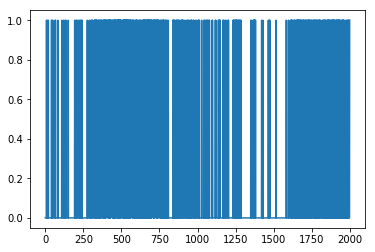

In [50]:
plt.plot(rList)

# Create an agent

In [23]:
createAgentResp = stub.CreateAgent(v1.CreateAgentRequest(api="v1", x=0, y=0), metadata=metadataTraining)
agentId = createAgentResp.id